# Project Proposal (Group 93)
## Water Potability

### Introduction
* Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal.
* Clearly state the question you will try to answer with your project.
* Identify and describe the dataset that will be used to answer the question.

Potable water (water that is safe to drink) is a basic requirement for human life. Lack of access to potable water is an issue that continues to affect many regions globally. The United Nations Sustainable Development Goal 6 is accordingly: "Ensure availability and sustainable management of water and sanitation for all”. According to the most recent report from the World Health Organization (WHO) (https://www.who.int/publications/i/item/9789240060807), in 2020 an estimated 26% of the global population (1.97 billion individuals) did not had access to safely managed drinking water services. Researching sufficiently fast, reliable, and cost-effective ways of evaluating the safety of drinking water is crucial to addressing this issue. In 2016, UNICEF called for the production of rapid-test kits for detecting the bacterium *Escherichia coli* (usually present in fecally contaminated water) (https://www.unicef.org/innovation/rapid-water-quality-testing). Apart from microbes, various other factors affect water potability.

In this project, we will utilize a synthetically generated dataset (https://www.kaggle.com/datasets/adityakadiwal/water-potability) containing over 3000 observations, each representing a sample of water. Each observation contains nine variables that affect water potability (pH, hardness, total dissolved solids, chloramines, sulfate, conductivity, organic carbon, trihalomethanes, and turbidity) as well as a score indicating whether or not the water is potable. Using this dataset, we aim to demonstrate how a classification model can be trained to accurately evaluate whether or not an unknown sample of water is potable based on measurable variables.

### Content


- **pH value**: PH is an important parameter in evaluating the acid–base balance of water.WHO has recommended maximum permissible limit of pH from 6.5 to 8.5.

- **Hardness**: Hardness is defined as the capacity of water to precipitate soap caused by Calcium and Magnesium.

- **Solids (Total dissolved solids - TDS)**: Water has the ability to dissolve a wide range of inorganic and some organic minerals or salts such as potassium, calcium, sodium, bicarbonates, chlorides, magnesium, sulfates etc.

- **Chloramines**: Chlorine and chloramine are the major disinfectants used in public water systems.Chlorine levels up to 4 milligrams per liter (mg/L or 4 parts per million (ppm)) are considered safe in drinking water.

- **Sulfate**: Sulfates are naturally occurring substances that are found in minerals, soil, and rocks.It ranges from 3 to 30 mg/L in most freshwater supplies, although much higher concentrations (1000 mg/L) are found in some geographic locations.

- **Conductivity**: Pure water is not a good conductor of electric current rather s a good insulator. Increase in ions concentration enhances the electrical conductivity of water.According to WHO standards, EC value should not exceeded 400 μS/cm.

- **Organic_carbon**: Total Organic Carbon (TOC) in source waters comes from decaying natural organic matter (NOM) as well as synthetic sources.According to US EPA < 2 mg/L as TOC in treated / drinking water, and < 4 mg/Lit in source water which is use for treatment.

- **Trihalomethanes**: THMs are chemicals which may be found in water treated with chlorine.THM levels up to 80 ppm is considered safe in drinking water.

- **Turbidity**: The turbidity of water depends on the quantity of solid matter present in the suspended state.The mean turbidity value obtained for Wondo Genet Campus (0.98 NTU) is lower than the WHO recommended value of 5.00 NTU.

- **Potability**: Indicates if water is safe for human consumption where 1 means Potable and 0 means Not potable.



### Preliminary exploratory data analysis
* Demonstrate that the dataset can be read from the web into R.
* Clean and wrangle your data into a tidy format.
* Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
* Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

[WRITE HERE AND CODE BELOW]

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)

water_potability_raw <- read_csv("data/water_potability.csv") #Unedited "raw" dataset

head(water_potability_raw)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,204.8905,20791.32,7.300212,368.5164,564.3087,10.379783,86.99097,2.963135,0
3.716080,129.4229,18630.06,6.635246,NA,592.8854,15.180013,56.32908,4.500656,0
8.099124,224.2363,19909.54,9.275884,NA,418.6062,16.868637,66.42009,3.055934,0
8.316766,214.3734,22018.42,8.059332,356.8861,363.2665,18.436524,100.34167,4.628771,0
9.092223,181.1015,17978.99,6.546600,310.1357,398.4108,11.558279,31.99799,4.075075,0
5.584087,188.3133,28748.69,7.544869,326.6784,280.4679,8.399735,54.91786,2.559708,0


In [2]:
water_potability_raw <- water_potability_raw |>
mutate(Potability = as_factor(Potability))
head(water_potability_raw)

ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
NA,204.8905,20791.32,7.300212,368.5164,564.3087,10.379783,86.99097,2.963135,0
3.716080,129.4229,18630.06,6.635246,NA,592.8854,15.180013,56.32908,4.500656,0
8.099124,224.2363,19909.54,9.275884,NA,418.6062,16.868637,66.42009,3.055934,0
8.316766,214.3734,22018.42,8.059332,356.8861,363.2665,18.436524,100.34167,4.628771,0
9.092223,181.1015,17978.99,6.546600,310.1357,398.4108,11.558279,31.99799,4.075075,0
5.584087,188.3133,28748.69,7.544869,326.6784,280.4679,8.399735,54.91786,2.559708,0


ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.77683720,0.57407768,0.004678412,0.57932015,0.57173208,-0.806433540,1.24226049,2.06501278,0.83103939,0
-0.95078024,-0.22613551,0.771039751,0.25673958,-0.15736085,-1.826029972,-1.73021492,-0.72791054,-1.82215239,0
1.98251576,1.60883533,0.771156899,0.23701323,1.45938576,-1.786825117,-0.13393505,1.09734065,-1.67689098,0
2.58717211,0.96890398,0.399354712,1.21754670,1.70987430,1.664023454,1.09159957,0.32096114,0.49993436,0
0.02012306,-1.19671628,-0.369673929,-2.21299961,-1.22741108,-0.997937292,0.49979582,0.78359184,-0.68595884,0
-0.46828969,-0.27466537,2.173498354,1.56391193,0.75520266,1.083506171,-0.80026507,0.51126095,0.50735429,0
0.17894971,0.57786122,0.415957958,-1.69468148,0.06169875,0.506849002,-0.51317464,-0.24343772,-1.82139465,0
-0.27044683,-0.84117344,1.021056617,-0.80048390,-0.53744165,1.168818966,1.07869561,0.63243123,-0.29620527,0
-1.06697022,-1.68697392,-0.536401524,1.83181146,-0.11681543,0.543293070,-0.88419625,-0.60407523,1.08239366,0


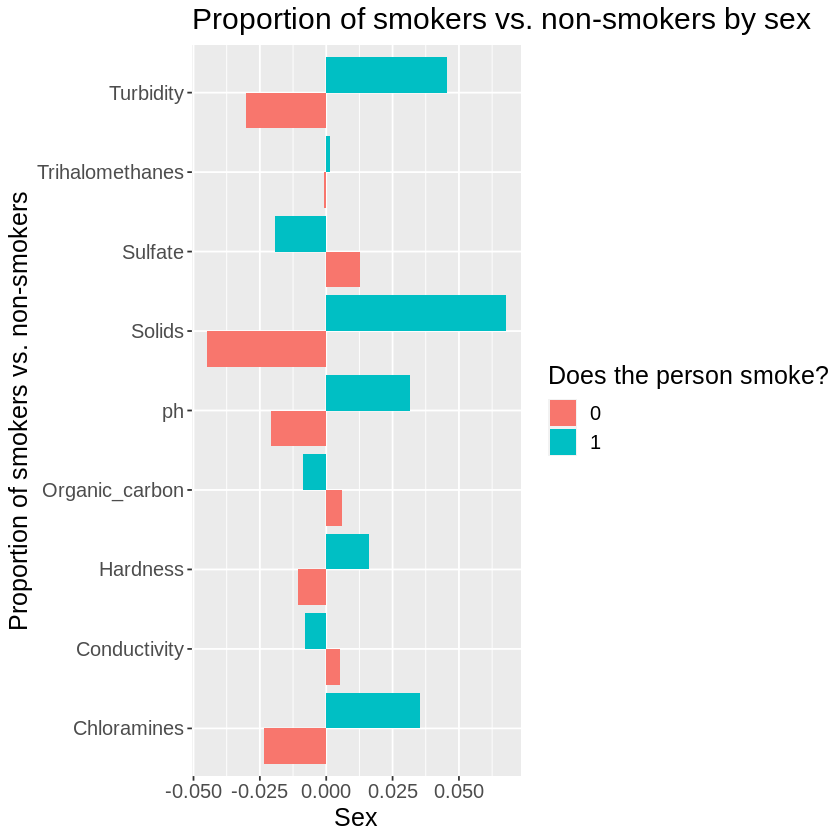

In [19]:
water_split <- water_potability_raw |>
    initial_split(prop = 0.75, strata = Potability)

water_train <- training(water_split) 
water_train <- water_train |> na.omit()

Potability <- select(water_train, Potability)

summary_table <- water_train |>
    select(-Potability) |>
    scale(center = TRUE, scale = TRUE)

summary_table <- bind_cols(summary_table, Potability)

summary_table

summary_table <- summary_table |>
    group_by(Potability) |>
    summarize(across(ph:Turbidity, mean, na.rm=TRUE))

summary_rowcount <- water_train |>
    group_by(Potability) |>
    summarize(n = n())

summary_table_with_n <- summary_table |>
    merge(summary_rowcount)

summary_table_longer <- summary_table |>
    pivot_longer(c(ph, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity), names_to = "Predictor")

bar_plot <- summary_table_longer |>
    ggplot(aes(y = Predictor,x = value, fill = Potability)) + 
    geom_bar(position = 'dodge', stat = "Identity") + 
    xlab("Sex") +
    ylab("Proportion of smokers vs. non-smokers") +
    labs(fill = "Does the person smoke?") +
    ggtitle("Proportion of smokers vs. non-smokers by sex") +
    theme(text = element_text(size = 15))

bar_plot

### Methods
* Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
* Describe at least one way that you will visualize the results.

[WRITE HERE]

### Expected outcomes and significance
- What do you expect to find? 
- What impact could such findings have?
- What future questions could this lead to?

[WRITE HERE]
- We expect to find whether the water is safe to drink or not based on several factors such as pH, hardness, conductivity etc.